# <font style="color:rgb(50,120,229)"> EE5/7382 – Fundamentals of Computer Vision - Final Examination
</font>

##### <font color="yellow">Preamble</font>

In [171]:
import cv2 as cv                    # Computer Vision
import matplotlib.pyplot as plt     # Plotting
import numpy as np                  # Numerics
import os
from scipy.signal import find_peaks # Peak detection

##### <font color="yellow">Helper function to read ToF sensor data</font>

In [172]:
def read_PCL(sz,fileName):
    """
    Function accepts two arguments
        sz specifies the number of rows & columns in the ToF sensor
        fileName specifies the path to the filename
    """
    
    # The data is stored as an array of float's
    # Each pixel has 4 floats (X,Y,Z,I)
    # Each frames has 320 x 240 such pixels

    # Number of bytes in file
    numBytes_in_file = os.path.getsize(fileName)
    
    # Number of bytes per pixel
    f = np.zeros(1,dtype='float32') # 4 bytes
    numAttributes_Per_Pixel = int(4) # X,Y,Z,I
    numBytes_Per_Pixel = numAttributes_Per_Pixel * 4

    # Number of bytes per frame
    numPixels_Per_Frame = int(sz[0]*sz[1]);
    numBytes_Per_Frame = numPixels_Per_Frame * numBytes_Per_Pixel
    # print(numBytes_Per_Frame)

    # Number of frames in file
    numFrames = int(numBytes_in_file/(numPixels_Per_Frame * numBytes_Per_Pixel))
    print('Detected {} frames in file'.format(numFrames))    
    
    # Allocate storage for data from ToF camera
    # arr = np.zeros(numPixels_Per_Frame * numAttributes_Per_Pixel, numFrames,'float32')  

    # fid_pcl = open(filename, 'rb', 0) # no buffering
    # for nn in range(numFrames)
    #     # arr(:,nn) = fread(fid_pcl, numPixels_Per_Frame * numAttributes_Per_Pixel, 'float' );
    # end
    # fid_pcl.close()

    with open(fileName, 'rb') as file:
        arr2D = np.fromfile(file, dtype=np.single).reshape(numFrames,numPixels_Per_Frame*numAttributes_Per_Pixel)
        arr2D = np.transpose(arr2D)

        print('Median filtering {} frames to reduce noise'.format(numFrames))    
        # Median filtering to mitigate noise
        arr1D = np.median(arr2D,1)
        nelm = arr1D.size
        """
        Read Point Cloud (Xw,Yw,Zw) from file
            Every 4th element beginning with 1st element corresponds to Xw
            Every 4th element beginning with 2nd element corresponds to Yw
            Every 4th element beginning with 3rd element corresponds to Zw
            Every 4th element beginning with 4rd element corresponds to intensity information I
        """        
        X = arr1D[range(0,nelm,4)].reshape(sz[0],sz[1])  
        Y = arr1D[range(1,nelm,4)].reshape(sz[0],sz[1])
        Z = arr1D[range(2,nelm,4)].reshape(sz[0],sz[1])         
        """
        WARNING: Depth Map is subject to geometric distortion
        Compensate using camera intrinsics undistort(), prior to dimensioning
        """
        Depth_Map_Distorted = Z     
        """
        WARNING: Intensity Image is subject to geometric distortion
        Compensate using camera intrinsics undistort(), prior to dimensioning
        """
        Intensity_Image_Distorted = arr1D[range(3,nelm,4)].reshape(sz[0],sz[1])
    #
    return X, Y, Z, Intensity_Image_Distorted, Depth_Map_Distorted


##### <font color="yellow">Read data from ToF sensor</font>

Detected 200 frames in file
Median filtering 200 frames to reduce noise


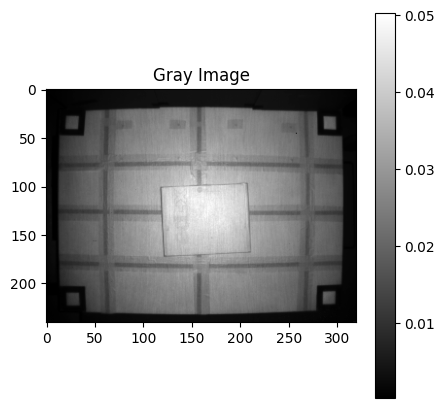

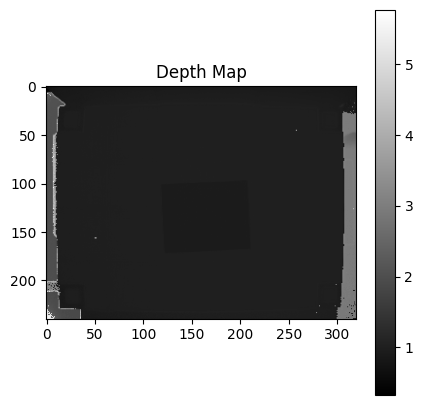

In [173]:
"""
depthImg reports the depth of each pixel in physical units
grayImg reports the monochrome intensity image acquired by the camera
Xw reports the world coordinates of the 
"""
[Xw,Yw,Zw,grayImg,depthMap] = read_PCL([240,320],'FedEx_Box2_PCL_300.txt')

plt.figure(figsize=[5,5])
plt.imshow( grayImg, cmap='gray' )
plt.title('Gray Image')
plt.colorbar()

plt.figure(figsize=[5,5])
plt.imshow( depthMap, cmap='gray' )
plt.title('Depth Map')
plt.colorbar()

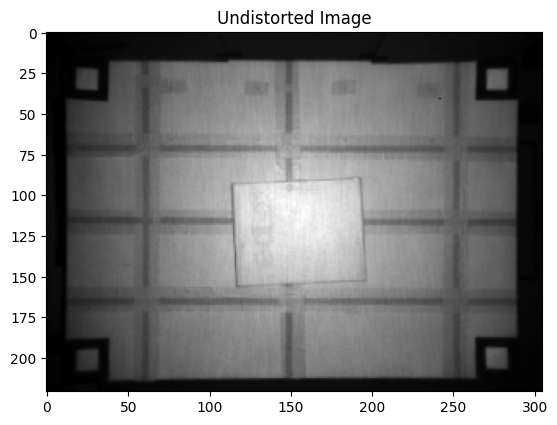

In [174]:
# Camera Intrinsic matrix
K = np.array([[225.607, 0, 158.205],
              [0, 224.547, 118.488],
              [0, 0, 1]])

# Radial distortion and Tangential distortion coefficients
distCoeffs = np.array([-0.202793, 0.176023, 0.000450451, -0.000485368, -0.0887613])

normalized_grayImg = cv.normalize(grayImg, None, 0, 255, cv.NORM_MINMAX)
grayImg_8bit = np.uint8(normalized_grayImg)


h, w = grayImg_8bit.shape[:2]
newCameraMatrix, roi = cv.getOptimalNewCameraMatrix(K, distCoeffs, (w, h), 1, (w, h))
undistortedImg = cv.undistort(grayImg_8bit, K, distCoeffs, None, newCameraMatrix)

x, y, w, h = roi
undistortedImg_cropped = undistortedImg[y:y+h, x:x+w]

plt.figure()
plt.imshow( undistortedImg_cropped, cmap='gray' )
plt.title('Undistorted Image')
plt.show()

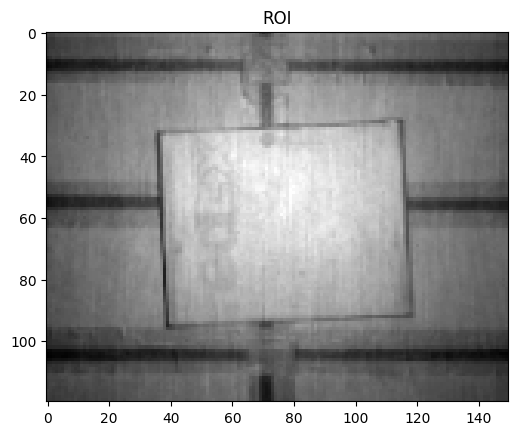

In [175]:
# setting the ROI manually
x2, y2 = 85, 70
w2, h2 = 150, 120
undistortedImg_cropped = undistortedImg[y2:y2+h2, x2:x2+w2]

plt.figure()
plt.imshow( undistortedImg_cropped, cmap='gray' )
plt.title('ROI')
plt.show()


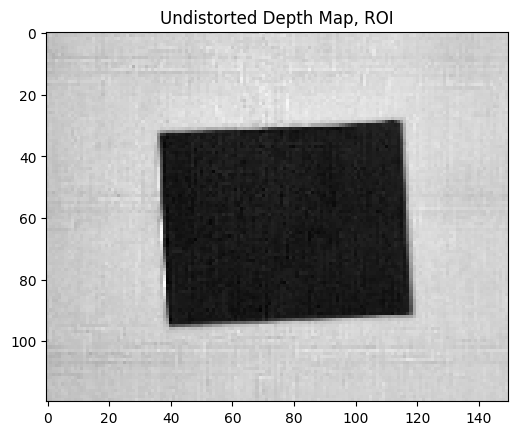

In [176]:
#DepthMap
undistortedDepthMap = np.zeros_like(depthMap)

mapx, mapy = cv.initUndistortRectifyMap(K, distCoeffs, None, newCameraMatrix, (w, h), 5)
undistortedDepthMap = cv.remap(depthMap, mapx, mapy, cv.INTER_LINEAR)

undistortedDepthMap_cropped = undistortedDepthMap[y2:y2+h2, x2:x2+w2]

plt.figure()
plt.imshow( undistortedDepthMap_cropped, cmap='gray' )
plt.title('Undistorted Depth Map, ROI')
plt.show()

##### <font color="yellow">Your approach to dimensioning the box</font>

Peaks: [0.9142493  0.94502985 0.9626187  0.99339926]
Depth/Height of the box: 0.07914996


Text(0.5, 1.0, 'Frequently occuring depths in Depth Map')

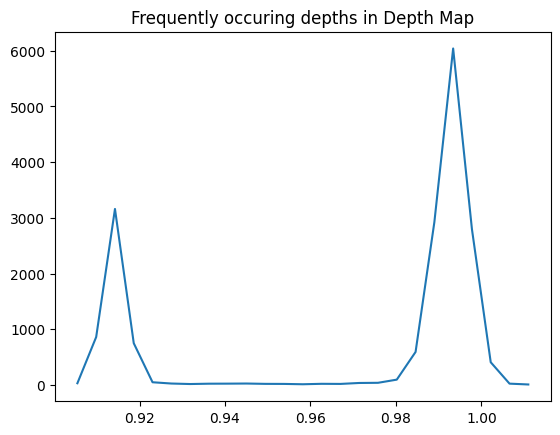

In [177]:
# Your code goes here

# Exemplar code to compute histogram
# WARNING: This is only for illustrative purposes
# You will have to undistort the depth map, and crop out a ROI before you attempt to compute the histogram
numBins = 25
[freq,binEdges] = np.histogram(np.ravel(undistortedDepthMap_cropped),numBins)

binCenters = 0.5*binEdges[0:-1] + 0.5*binEdges[1::]

#finding peaks
peaks, _ = find_peaks(freq, height=0)
peak_depth_values = binCenters[peaks]

if len(peak_depth_values) >= 2:
    top_peaks = peak_depth_values[np.argsort(freq[peaks])[-2:]]
    depth_difference = np.abs(top_peaks[1] - top_peaks[0])
else:
    depth_difference = None

print("Peaks:", peak_depth_values)
print("Depth/Height of the box:", depth_difference)

plt.plot(binCenters,freq)
plt.title('Frequently occuring depths in Depth Map')

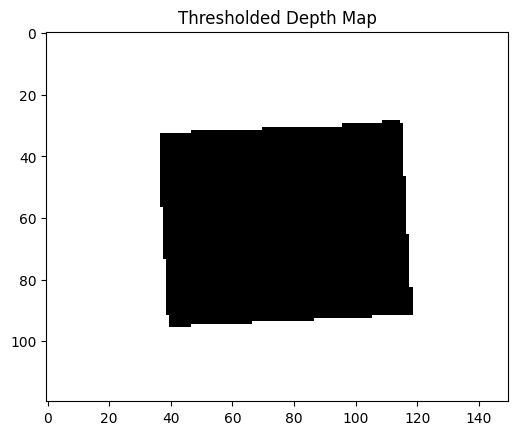

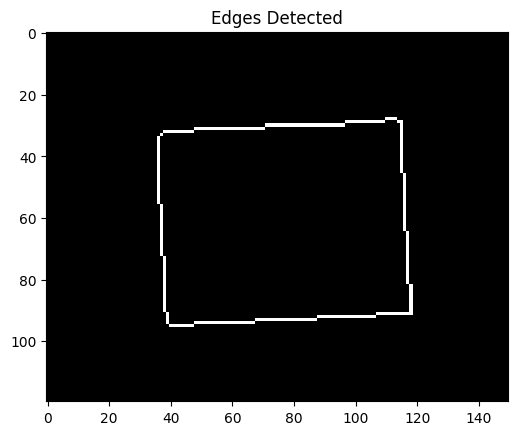

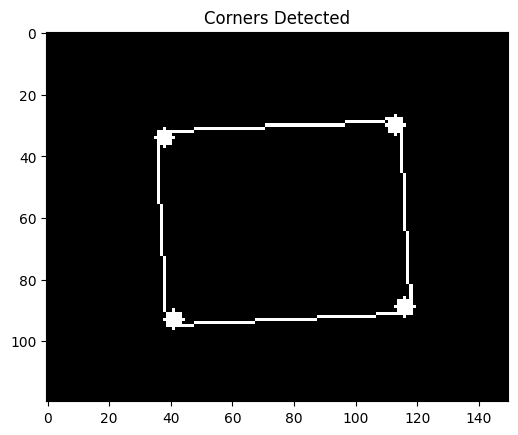

World Coordinates:
[[-0.1870731  -0.13132217  1.        ]
 [-0.51950959 -0.11350853  1.        ]
 [-0.20037056 -0.3940734   1.        ]
 [-0.53280705 -0.37625976  1.        ]]


In [178]:
# Inverse of Camera Intrinsic matrix
def pixel_to_world(x, y, Zw, K_inv):
    pixel_coords_homogeneous = np.array([x, y, 1])
    world_coords_homogeneous = Zw * np.dot(K_inv, pixel_coords_homogeneous)
    return world_coords_homogeneous

K_inv = np.linalg.inv(K)

# Threshold mask
median_depth = np.median(undistortedDepthMap_cropped)
box_min_depth = median_depth - depth_difference/2
box_max_depth = median_depth + depth_difference/2

box_mask = (undistortedDepthMap_cropped >= box_min_depth) & (undistortedDepthMap_cropped <= box_max_depth)
plt.figure()
plt.imshow(box_mask, cmap='gray')
plt.title('Thresholded Depth Map')
plt.show()

# Edge detection
edges = cv.Canny(np.uint8(box_mask * 255), 1, 100)
plt.figure()
plt.imshow(edges, cmap='gray')
plt.title('Edges Detected')
plt.show()

# Corner detection
corners = cv.goodFeaturesToTrack(edges, maxCorners=4, qualityLevel=0.01, minDistance=10)
Corner_image = np.copy(edges)

# World coordinates of corners
world_coordinates = []

if corners is not None:
    corners = np.int0(corners)
    
    for corner in corners:
        x, y = corner.ravel()
        cv.circle(Corner_image, (x, y), 3, 255, -1)
        world_coords = pixel_to_world(x, y, 1, K_inv)
        world_coordinates.append(world_coords)
        
    world_coordinates = np.array(world_coordinates)
    
plt.figure()
plt.imshow(Corner_image, cmap='gray')
plt.title('Corners Detected')
plt.show()

print("World Coordinates:")
print(world_coordinates)



In [179]:
def euclidian_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

length1 = euclidian_distance(world_coordinates[0], world_coordinates[1])
width1 = euclidian_distance(world_coordinates[0], world_coordinates[2])

length2 = euclidian_distance(world_coordinates[2], world_coordinates[3])
width2 = euclidian_distance(world_coordinates[1], world_coordinates[3])

length = (length1 + length2)/2 
width = (width1 + width2)/2

print("Length of the box:", length * 100, " cms")
print("Width of the box:", width * 100, " cms")
print("Height of the box:", depth_difference * 100, " cms")
print("Volume of the box:", length * width * depth_difference * 100**3, " cubic cms")

Length of the box: 33.29134243384234  cms
Width of the box: 26.308749545693505  cms
Height of the box: 7.914996147155762  cms
Volume of the box: 6932.377791366344  cubic cms
